<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-06-Rotterdam-University/3-Rotterdam-university-research-about-design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

# 3. Analyze Rotterdam's publications output about 'design' 

This Notebook shows how it's possible to analyse an arbitrary dataset - e.g. publications matching the keyword 'design' - so to better undertand what research exists in that area. 


In [12]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
from plotly.offline import init_notebook_mode # needed for exports 
init_notebook_mode(connected=True)
import time

In [13]:
GRIDID = "grid.6906.9" # Erasmus University Rotterdam

## Extracting all publications about 'design' 

In [14]:
data = dslqueryall(f"""search publications in title_abstract_only for "design" where research_orgs.id="{GRIDID}" return publications[basics+FOR]""")
df = json_normalize(data.publications)
df.head()

1000 / 1874
1874 / 1874


,FOR,author_affiliations,id,issue,journal.id,journal.title,pages,title,type,volume,year
0,"[{'id': '3468', 'name': '1701 Psychology'}]","[[{'first_name': 'Kim', 'last_name': 'Melchior...",pub.1114921671,1,jour.1297400,Trials,277,Metacognitive therapy versus exposure and resp...,article,20,2019
1,"[{'id': '3177', 'name': '1117 Public Health an...","[[{'first_name': 'Erik', 'last_name': 'Baltaxe...",pub.1117052073,1,jour.1327417,BMC Health Services Research,370,Evaluation of integrated care services in Cata...,article,19,2019
2,"[{'id': '3177', 'name': '1117 Public Health an...","[[{'first_name': 'Siri', 'last_name': 'Wiig', ...",pub.1114053482,1,jour.1039457,BMC Research Notes,259,How to deal with context? A context-mapping to...,article,12,2019
3,"[{'id': '2358', 'name': '0104 Statistics'}]","[[{'first_name': 'Stefano', 'last_name': 'Tass...",pub.1116083197,NaN,jour.1313652,Social Networks,10-22,Does it take three to dance the Tango? Organiz...,article,59,2019
4,"[{'id': '3468', 'name': '1701 Psychology'}, {'...","[[{'first_name': 'A.', 'last_name': 'Eenshuist...",pub.1114041703,NaN,jour.1092724,Children and Youth Services Review,135-147,One size does not fit all: A systematic review...,article,103,2019


## Getting an Overview: Publications by year

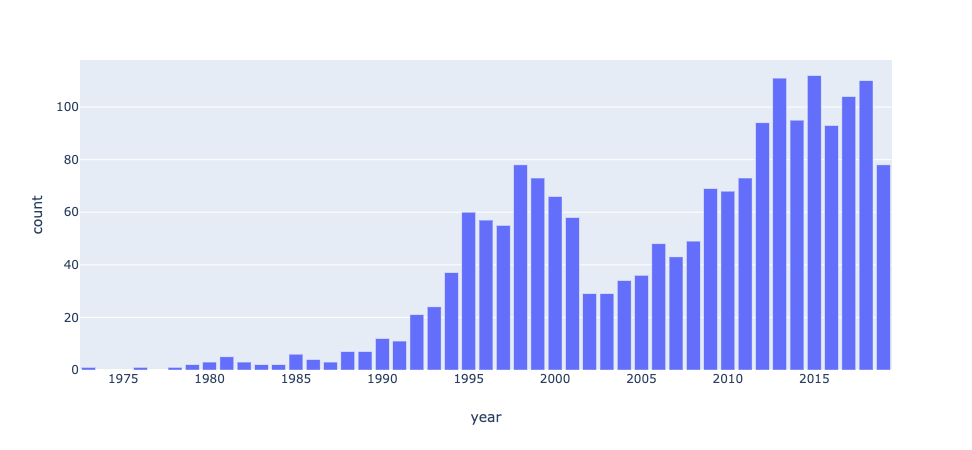

In [15]:
dfyear = df.groupby("year", as_index=False)['id'].count()
dfyear.rename(columns={'id': 'count'}, inplace=True)
px.bar(dfyear, x="year", y="count", height=200)

## More details: distributions of pubs per Journals, Years and Type

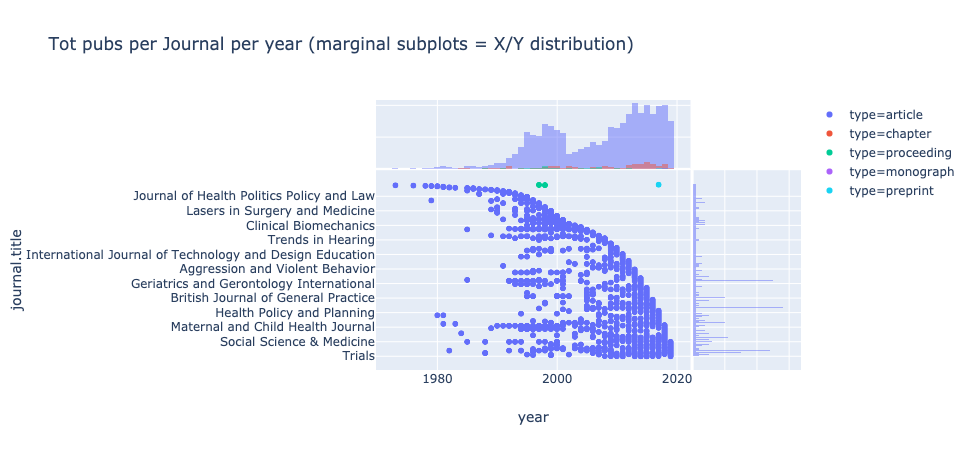

In [16]:
px.scatter(df, x="year", y="journal.title", color="type", marginal_x="histogram", marginal_y="histogram", height=900, title="Tot pubs per Journal per year (marginal subplots = X/Y distribution)")

## Analysing the distribution of broad Subject Areas

In [17]:
# ensure that all pubs have a valid (empty, even) FOR value 
for x in data.publications:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] # also remove the digit prefix to improve legibility

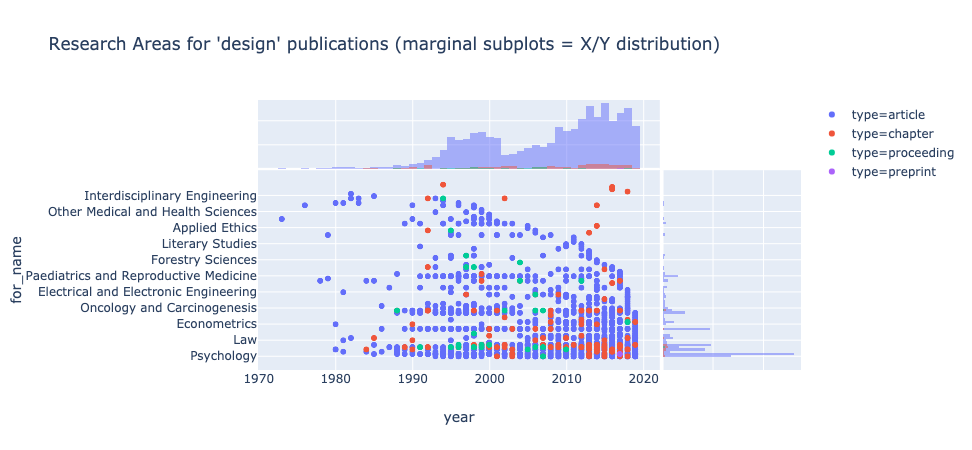

In [18]:
df2 = json_normalize(data.publications, record_path=['FOR'], meta=["id", "type", ["journal", "title"], "year"], errors='ignore', record_prefix='for_')
px.scatter(df2, x="year", y="for_name", color="type", marginal_x="histogram", marginal_y="histogram", height=800, title="Research Areas for 'design' publications (marginal subplots = X/Y distribution)")

# How does Rotterdam compare to the rest of the Netherlands? (in this area)

### First let's pull out the top 30 dutch institutions active in the 'design' area

In [19]:
df = dslquery(f"""search publications in title_abstract_only for "design" where research_org_countries.id="NL" return research_orgs sort by count limit 1000""").as_dataframe()

In [20]:
grid_ids = df.query("country_name=='Netherlands'")[:30][['id','name']]
grid_ids.head(30)

,id,name
0,grid.5292.c,Delft University of Technology
1,grid.6852.9,Eindhoven University of Technology
2,grid.6214.1,University of Twente
3,grid.5645.2,Erasmus University Medical Center
4,grid.5012.6,Maastricht University
5,grid.7692.a,University Medical Center Utrecht
6,grid.5477.1,Utrecht University
7,grid.10417.33,Radboud University Nijmegen Medical Centre
8,grid.10419.3d,Leiden University Medical Center
9,grid.12380.38,VU University Amsterdam


### Second obtain detailed publication per year figures, for each institution in the NL top-30 

Results are automatically saved into a table so that we can visualise them later. PS the table is seeded with data for the Netherlands as a whole, so that we can also compare each single institution output with the country output. 

In [21]:
seed = dslquery(f"""search publications in title_abstract_only for "design" where research_org_countries.id="NL" return year limit 1000""").as_dataframe()
seed['group'] = "The Netherlands"
for index, row in grid_ids.iterrows():
    temp = dslquery(f"""search publications in title_abstract_only for "design" where research_orgs.id="{row['id']}" return year limit 1000""").as_dataframe()
    temp['group'] = row['name']
    seed = seed.append(temp)
    print("..loading: ", row['name'])
    time.sleep(1)

..loading:  Delft University of Technology
..loading:  Eindhoven University of Technology
..loading:  University of Twente
..loading:  Erasmus University Medical Center
..loading:  Maastricht University
..loading:  University Medical Center Utrecht
..loading:  Utrecht University
..loading:  Radboud University Nijmegen Medical Centre
..loading:  Leiden University Medical Center
..loading:  VU University Amsterdam
..loading:  VU University Medical Center
..loading:  Wageningen University & Research
..loading:  University of Groningen
..loading:  University of Amsterdam
..loading:  Academic Medical Center
..loading:  Radboud University Nijmegen
..loading:  University Medical Center Groningen
..loading:  Erasmus University Rotterdam
..loading:  Leiden University
..loading:  Maastricht University Medical Centre
..loading:  Netherlands Organisation for Applied Scientific Research
..loading:  Tilburg University
..loading:  Philips (Netherlands)
..loading:  EMGO Institute for Health and Care R

### Third, let's sort the data by year and visualize it

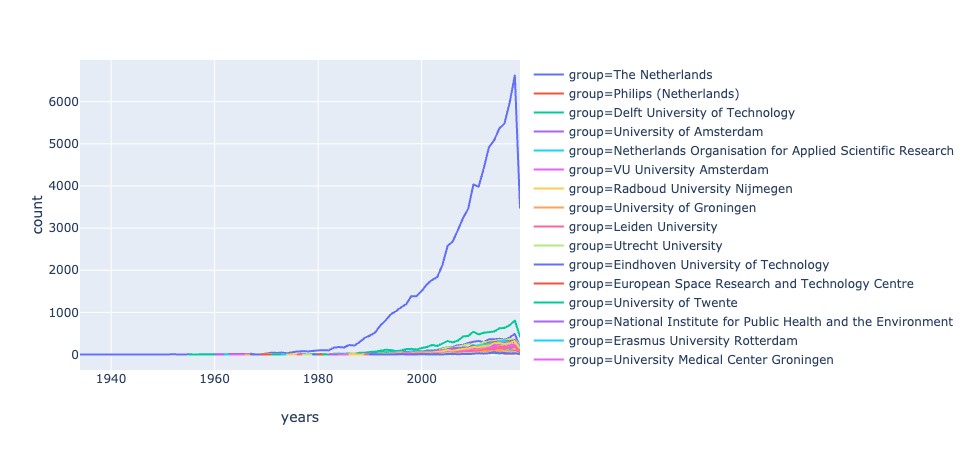

In [22]:
# rename columns and sort by year
seed.rename(columns={'id':'years'}, inplace=True)
seed.sort_values(by="years", inplace=True)
seed.reset_index(drop=True)
px.line(seed, x="years", y="count", color="group")

### Next steps

* compare the distribution segmenting by broad subject area
* used citations as well 

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 